In [1]:
from G11_code.data_collection import *
from G11_code.helper_functions import *
from G11_code.indexing import *
from G11_code.clustering import *
import seaborn as sns
from tqdm import tqdm

# Data Preparation

In [2]:
article_path = os.path.join("..", "BBC News Summary", "BBC News Summary", "News Articles")
summary_path = os.path.join("..", "BBC News Summary", "BBC News Summary", "Summaries")
print("Article path:", article_path)
print("Summary path:", summary_path)
_article_file_paths_by_cat, _articles_by_cat, _summary_file_paths_by_cat, _summaries_by_cat, category_names = read_files(article_path, summary_path)

Article path: ..\BBC News Summary\BBC News Summary\News Articles
Summary path: ..\BBC News Summary\BBC News Summary\Summaries
Number of Categories: 5
Number of Articles in 'business' Category: 510
Number of Articles in 'entertainment' Category: 386
Number of Articles in 'politics' Category: 417
Number of Articles in 'sport' Category: 511
Number of Articles in 'tech' Category: 401


In [3]:
_summary_sentence_indices_by_cat, faulty_summary_ids = get_summary_sentence_indices(_articles_by_cat, _summaries_by_cat)

number of found summaries: 2220
number of summaries: 2225
99.78%


In [4]:
articles_by_cat = remove_entries(_articles_by_cat, faulty_summary_ids)
articles = flatten(articles_by_cat)
article_file_paths_by_cat = remove_entries(_article_file_paths_by_cat, faulty_summary_ids)
article_file_paths = flatten(article_file_paths_by_cat)
summaries_by_cat = remove_entries(_summaries_by_cat, faulty_summary_ids)
summaries = flatten(summaries_by_cat)
summary_file_paths_by_cat = remove_entries(_summary_file_paths_by_cat, faulty_summary_ids)
summary_file_paths = flatten(summary_file_paths_by_cat)
summary_sentence_indices_by_cat = remove_entries(_summary_sentence_indices_by_cat, faulty_summary_ids)
summary_sentence_indices = flatten(summary_sentence_indices_by_cat)

In [5]:
dict_path_to_articleID = {path:i for i, path in enumerate(article_file_paths)}
def map_path_to_articleID(path):
    path = os.path.normpath(path)
    return dict_path_to_articleID.get(path)

# Options

In [6]:
path = os.path.join(article_path, 'tech', '199.txt')
d = map_path_to_articleID(path)
compute_index = True

# Experiments

## Unupervised

In [7]:
if compute_index:
    index_path = './index/Index.pkl'
    I = indexing(None, index_path = index_path)

In [8]:
# load embeddings 
sentence_embeddings_path = os.path.join('./embeddings', 'sentence_embeddings.pkl')
sentence_embeddings_by_cat = pickle_load(sentence_embeddings_path)
document_embeddings_path = os.path.join('./embeddings', 'document_embeddings.pkl')
document_embeddings_by_cat = pickle_load(document_embeddings_path)

In [143]:
np.random.seed(42)
d=0
dM = bert_compute_dissimilarity_matrix(d, file_path=sentence_embeddings_path)
dM2 = tf_idf_compute_dissimilarity_matrix(d, I, conversion_function=lambda S: np.exp(-(S+0.5)))

<Axes: ylabel='Density'>

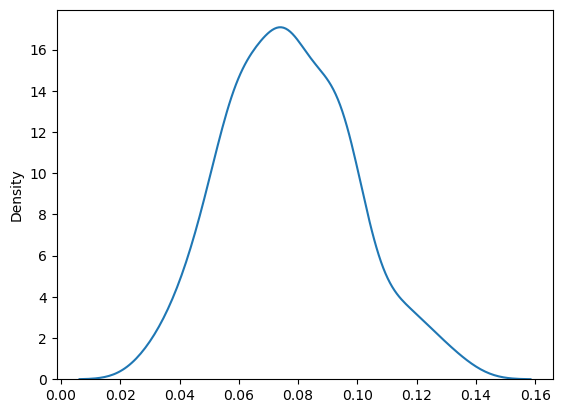

In [130]:
sns.kdeplot(dM.compressed())

<Axes: ylabel='Density'>

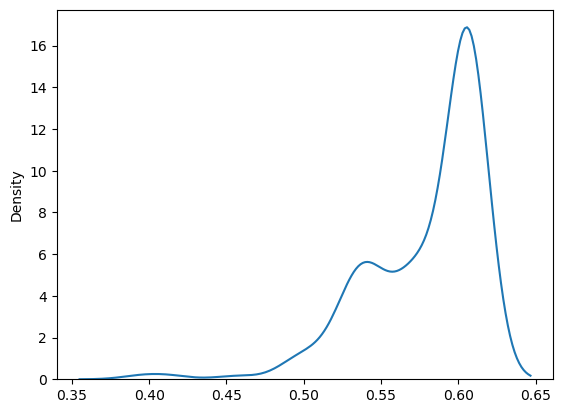

In [144]:
sns.kdeplot(dM2.compressed())

In [12]:
n_clust, labels = sentence_clustering(dM, algorithm='agglomerative', linkage='complete', kmax=len(dM)//2, evaluate=dunn_index)
n_clust, len(labels), labels 

(4, 11, array([4, 2, 3, 1, 1, 2, 1, 2, 3, 2, 1], dtype=int32))

In [13]:
n_clust, (labels, indices) = sentence_clustering(dM, kmax=len(dM)//2)
n_clust, len(labels), labels, indices

(5,
 11,
 array([0, 3, 4, 1, 1, 3, 1, 3, 2, 3, 1], dtype=uint64),
 array([0, 4, 8, 7, 2], dtype=uint64))

In [16]:
ss = [tf_idf_compute_dissimilarity_matrix(d_i, I, conversion_function=lambda S: S).compressed() for d_i in tqdm(range(len(articles)))]

100%|██████████| 2220/2220 [01:05<00:00, 34.02it/s]


In [14]:
ds = [np.log(bert_compute_dissimilarity_matrix(d_i, file_path=sentence_embeddings_path).compressed()) for d_i in tqdm(range(len(articles)))]

 34%|███▍      | 761/2220 [01:52<04:43,  5.15it/s]C:\Users\marti\AppData\Local\Temp\ipykernel_25800\1852726668.py:1: RuntimeWarning: divide by zero encountered in log
  ds = [np.log(bert_compute_dissimilarity_matrix(d_i, file_path=sentence_embeddings_path).compressed()) for d_i in tqdm(range(len(articles)))]
 53%|█████▎    | 1182/2220 [02:48<02:56,  5.88it/s]C:\Users\marti\AppData\Local\Temp\ipykernel_25800\1852726668.py:1: RuntimeWarning: divide by zero encountered in log
  ds = [np.log(bert_compute_dissimilarity_matrix(d_i, file_path=sentence_embeddings_path).compressed()) for d_i in tqdm(range(len(articles)))]
 79%|███████▉  | 1757/2220 [03:58<00:43, 10.69it/s]C:\Users\marti\AppData\Local\Temp\ipykernel_25800\1852726668.py:1: RuntimeWarning: divide by zero encountered in log
  ds = [np.log(bert_compute_dissimilarity_matrix(d_i, file_path=sentence_embeddings_path).compressed()) for d_i in tqdm(range(len(articles)))]
100%|██████████| 2220/2220 [05:08<00:00,  7.19it/s]


In [106]:
fail = set([761, 1182, 1757])
a1 = np.array([np.mean(sims) for i,sims in enumerate(ss) if i not in fail])
b = np.array([np.mean(diss) for i,diss in enumerate(ds) if i not in fail])
a2 = np.ones_like(a1)
a = np.c_[a1, a2]
x = np.linalg.lstsq(a,b)

C:\Users\marti\AppData\Local\Temp\ipykernel_25800\4214073443.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(a,b)


In [107]:
x

(array([-1.89388526, -2.34072655]),
 array([44.9459665]),
 2,
 array([47.15121042,  1.21521543]))

In [108]:
fst = -x[0][0]
snd = -x[0][1]/fst
fst,snd

(1.8938852576568754, 1.2359389479453475)

In [128]:
import scipy.optimize
s_train = np.array(flatten([sims for i,sims in enumerate(ss) if i not in fail]))
d_train = np.array(flatten([diss for i,diss in enumerate(ds) if i not in fail]))
def fun(x, s, d):
    return np.exp(-x[0]*(s+x[1])) - d
res = scipy.optimize.least_squares(fun, np.array([1.5,1.5]), args=(s_train,d_train))
res.x

array([4.89203618, 4.85772089])

## Supervised

In [ ]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed

# create a sequence classification instance
def get_sequence(n_timesteps):
	# create a sequence of random numbers in [0,1]
	X = array([random() for _ in range(n_timesteps)])
	# calculate cut-off value to change class values
	limit = n_timesteps/4.0
	# determine the class outcome for each item in cumulative sequence
	y = array([0 if x < limit else 1 for x in cumsum(X)])
	# reshape input and output data to be suitable for LSTMs
	X = X.reshape(1, n_timesteps, 1)
	y = y.reshape(1, n_timesteps, 1)
	return X, y

# define problem properties
n_timesteps = 10
# define LSTM
model = Sequential()
model.add(LSTM(20, input_shape=(None, 1), return_sequences=True))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# train LSTM
for epoch in range(1000):
	# generate new random sequence
	X,y = get_sequence(n_timesteps)
	# fit model for one epoch on this sequence
	model.fit(X, y, epochs=1, batch_size=1, verbose=2)
# evaluate LSTM
X,y = get_sequence(n_timesteps)
yhat = model.predict_classes(X, verbose=0)
for i in range(n_timesteps):
	print('Expected:', y[0, i], 'Predicted', yhat[0, i])

In [ ]:

from random import random
import tqdm
import numpy.random as rnd 
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

In [ ]:
# create a sequence classification instance
def get_sequence(n_timesteps):
	# create a sequence of random numbers in [0,1]
	X = array([(random(),random()) for _ in range(n_timesteps)])
	# calculate cut-off value to change class values
	limit = n_timesteps/4.0
	# determine the class outcome for each item in cumulative sequence
	y = array([0 if x[0] < limit else 1 for x in cumsum(X,axis=0)])
	# reshape input and output data to be suitable for LSTMs
	X = X.reshape(1, n_timesteps, 2)
	y = y.reshape(1, n_timesteps, 1)
	return X, y

# define LSTM
model = Sequential()
model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(None, 2)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# train LSTM
for epoch in range(50):
    #print(epoch, n_timesteps)
    n_timesteps = rnd.randint(2,20)
	# generate new random sequence
    X,y = get_sequence(n_timesteps)
	# fit model for one epoch on this sequence
    model.fit(X, y, epochs=1, batch_size=1, verbose=2)